Since linear models don't capture interactions between features, here, we test for this. This can reveal synergies or antagonisms that have outsized effects on metastatic potential. 

In [ ]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--feature_type", type=str, required=True, help="how to filter features")
args = parser.parse_args()
feature_type = args.feature_type

# python 05_perturbation_interactions_residuals_pairs.py --feature_type all 
# feature_type =  'top400', 'enriched', 'transcription_factors'

In [1]:
import os
import itertools
import random
from multiprocessing import Pool
from math import comb

from tqdm import tqdm 

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

import seaborn as sns
import matplotlib.pyplot as plt 

import sys
sys.path.insert(1, '../')
from utils import read_pickled_object

/nobackup/users/hmbaghda/Software/miniforge3/envs/metastatic_potential/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42 + 3

n_cores = 80
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

Load data:

In [3]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'), index_col = 0)
expr_joint = X.copy()

mp_joint=pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), index_col = 0)['mean']
y = mp_joint.values.ravel()

expr_protein = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0)
expr_rna = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)

protein_cols = expr_protein.columns
rna_cols = expr_rna.columns

X_protein = X[protein_cols].values
X_rna = X[rna_cols].values


As in [Notebook 04](./04_feature_analysis.ipynb), we fit the consensus linear SVR on the entire dataset:

In [4]:
best_pipeline = read_pickled_object(os.path.join(data_path, 'processed', 
                                                 'best_model_svr_linear_joint.pickle'))
X = (X_protein, X_rna)
best_pipeline.fit(X, y)

# load from notebook 04
# best_pipeline = read_pickled_object(os.path.join(data_path, 'interim', 'best_linearSVR_joint_fitted_allsamples.pickle'))


Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('protein_pipeline',
                                                 Pipeline(steps=[('select_protein',
                                                                  ModalitySelector(modality='protein')),
                                                                 ('feature_selection_protein',
                                                                  FeatureSelector(n_features=500)),
                                                                 ('mean_centering_protein',
                                                                  MeanCenterer())])),
                                                ('rna_pipeline',
                                                 Pipeline(steps=[('select_rna',
                                                                  ModalitySelector(modality='rna')),
                                                                 ('feature_selection_rna',
                                                                  FeatureSelector(n_features=19138)),
                                                                 ('mean_centering_rna',
                                                                  MeanCenterer())]))])),
                ('model',
                 SVR(C=np.float64(0.8708199642350806),
                     epsilon=np.float64(0.7444800190713263),
                     kernel='linear'))])

In [5]:
model_coefs = pd.read_csv(os.path.join(data_path, 'interim', 'joint_features.csv'), 
                          index_col = 0)
if not np.allclose(model_coefs['SVM coefficient'].values, 
                   best_pipeline.named_steps['model'].coef_.flatten()):
    raise ValueError('Inconsitency between Notebook 04 and 05')
model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs.set_index('feature_name', inplace = True)


Get the prediction:

In [6]:
# get prediction
y_pred = best_pipeline.predict(X)
residuals = y - y_pred

Center the data:

In [7]:
X_map = {'Transcriptomics': X_rna, 'Proteomics': X_protein}
X_map = {k: X_ - np.mean(X_, axis=0) for k, X_ in X_map.items()} # center the data

# # center and scale the data
# from sklearn.preprocessing import StandardScaler
# for k, X_ in X_map.items():
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X_)
#     X_map[k] = X_scaled
    
# for k, X_ in X_map.items():
#     X_centered = X_ - np.mean(X_, axis=0) # mean center
#     X_map[k] = X_centered
#     X_scaled = X_centered / np.std(X_, axis=0) # scale
#     X_map[k] = X_scaled

Get the interactions:

In [8]:
def get_interaction_value(feature_1: str, feature_2: str, residuals, X_map, model_coefs):
    X_1 = X_map[model_coefs.loc[feature_1,'Modality']][:, model_coefs.loc[feature_1, 'feature_index']]
    X_2 = X_map[model_coefs.loc[feature_2,'Modality']][:, model_coefs.loc[feature_2, 'feature_index']]

    ols_df = pd.DataFrame({"residual": residuals, 
                           "X_tilda": X_1 * X_2})

    ols_interaction = smf.ols("residual ~ X_tilda", data=ols_df).fit()


    coef = float(ols_interaction.params.X_tilda)
    pval = float(ols_interaction.pvalues.X_tilda)
    
    se = ols_interaction.bse.X_tilda
    
    t_statistic = float(abs(coef))/se
    
    return coef, pval, t_statistic

## GA
The top 50 features have no significant interactions. However, it is possible for interactions to occur non-intuitively across features that don't have high ranks. So, let's use a genetic algorithm to find a subset of 25 choose 2 features with the highest coefficients within the top 400 instead. 

In [9]:
def get_interaction_value_ga(feature_1: str, feature_2: str, 
                             residuals = residuals, 
                             X_map = X_map, 
                             model_coefs = model_coefs):
    X_1 = X_map[model_coefs.loc[feature_1,'Modality']][:, model_coefs.loc[feature_1, 'feature_index']]
    X_2 = X_map[model_coefs.loc[feature_2,'Modality']][:, model_coefs.loc[feature_2, 'feature_index']]

    ols_df = pd.DataFrame({"residual": residuals, 
                           "X_tilda": X_1 * X_2})

    ols_interaction = smf.ols("residual ~ X_tilda", data=ols_df).fit()


    coef = abs(ols_interaction.params.X_tilda)
    se = ols_interaction.bse.X_tilda
    
    t_statistic = float(coef)/se
    
    return coef, t_statistic

def generate_individual(seed, n_pairs):
    random.seed(seed)
    gene_pairs = list(itertools.combinations(all_features, 2))
    return random.sample(gene_pairs, n_pairs)


# --- Fitness function ---
def evaluate_solution(pair_subset):
    """Evaluate solution based on hybrid scoring of abs(coef) and t-statistic."""
#     ALPHA = 0.2
    coefs, t_stats = [], []

    for f1, f2 in pair_subset:
        coef, t_stat = get_interaction_value_ga(f1, f2)
        coefs.append(coef)
        t_stats.append(t_stat)
        
    # log-transform
    coefs = np.log1p(np.array(coefs))
    t_stats = np.log1p(np.array(t_stats))

#     coef_norm = np.log1p(np.array(coefs))
#     tstat_norm = np.log1p(np.array(t_stats))

#     # log-transform due to extreme range of coefs
#     coef_arr = np.log1p(np.array(coefs)) 
#     tstat_arr = np.log1p(np.array(t_stats))
    
#     # Min-max normalize both arrays -- not doing because makes changes too sublte
#     # Avoid divide-by-zero with epsilon
#     eps = 1e-8
#     coef_norm = (coef_arr - coef_arr.min()) / (coef_arr.max() - coef_arr.min() + eps)
#     tstat_norm = (tstat_arr - tstat_arr.min()) / (tstat_arr.max() - tstat_arr.min() + eps)

#     hybrid_scores = ALPHA * coef_norm + (1 - ALPHA) * tstat_norm
    return coefs, t_stats #float(np.median(hybrid_scores))


def rank_selection(seed, pop, scores, num_selected):
    '''Assign probability of selection according to rank order of the population'''
    
    # rank order by lowest fitness to highest fitness
    sorted_pop = [x for _, x in sorted(zip(scores, pop), key=lambda x: x[0])] 
    ranks = list(range(1, len(sorted_pop) + 1))
    probs = [r / sum(ranks) for r in ranks]
    
    # select according to probability of rank
    random.seed(seed)
    selected_pop = random.choices(sorted_pop, weights=probs, k=num_selected)
    return selected_pop

def score_fitness(raw_fitness_components, lambda_ = 0.25):
    '''Scores fitness of each individual in population for a given generation.
    
    
    Evaluates by a hybrid scoring of t-statistic and abs coefficient. 
    
    These components are log-transformed in evaluate_solution.
    
    T-statistic controls for the SE. Since t-statistic is normalized and coefficient is not, 
    we min-max scale both so that they are on similar scales. 
    
    lambda_ controls weighting of coef vs t-statistic on score. 
    '''
    # min-max scale individuals according to population
    population_coefs = [c for coefs, _ in raw_fitness_components for c in coefs]
    population_tstats = [t for _, tstats in raw_fitness_components for t in tstats]

    coef_min, coef_max = np.min(population_coefs), np.max(population_coefs)
    tstat_min, tstat_max = np.min(population_tstats), np.max(population_tstats)

    eps = 1e-12 # avoid dividing by 0

    fitness_scores = []
    for coefs, tstats in raw_fitness_components:
        # scale individuals 
        coef_arr = (np.array(coefs) - coef_min) / (coef_max - coef_min + eps)
        tstat_arr = (np.array(tstats) - tstat_min) / (tstat_max - tstat_min + eps)

        # Compute hybrid score
        hybrid_scores = lambda_ * coef_arr + (1 - lambda_) * tstat_arr
        fitness_scores.append(float(np.median(hybrid_scores)))
        
    return fitness_scores


In [10]:
class SeedTracker:
    def __init__(self):
        self._gi_seed = 42
        self._rs_seed = 888
        self._offspring_1 = 2024
        self._offspring_2a = 4048
        self._offspring_2b = 64768
        self._offspring_3 = 8096
        self._mutation_seed_1 = 16192
        self._mutation_seed_2 = 32384

    @property
    def gi_seed(self):
        self._gi_seed += 1
        return self._gi_seed
    
    @property
    def rs_seed(self):
        self._rs_seed += 1
        return self._rs_seed
    
    @property
    def offspring_1(self):
        self._offspring_1 += 1
        return self._offspring_1
    
    @property
    def offspring_2a(self):
        self._offspring_2a += 1
        return self._offspring_2a
    
    @property
    def offspring_2b(self):
        self._offspring_2b += 1
        return self._offspring_2b

    @property
    def offspring_3(self):
        self._offspring_3 += 1
        return self._offspring_3
    
    @property
    def mutation_seed_1(self):
        self._mutation_seed_1 += 1
        return self._mutation_seed_1

    @property
    def mutation_seed_2(self):
        self._mutation_seed_2 += 1
        return self._mutation_seed_2
    
seed_tracker = SeedTracker()


In [11]:
# --- Parameters ---
POP_SIZE = 80*9 # no. of solutions
n_cores = min(n_cores, POP_SIZE)
N_GENES = comb(25,2) # feature pairs per solution (find n pairs of highly interacting genes)
N_GENERATIONS = 300 # no. of iterations of GA
#MUTATION_RATE = 0.2
GENE_MUTATION_RATE = 0.1 # probability of mutating each gene in each child


# injecting some randomness and monitoring convergence
patience = min(15, np.round(N_GENERATIONS / 10)) # early stopping after plateau for n iterations
n_restart_individuals = max(int(np.round(POP_SIZE*0.15)), 2) # randomly replace the bottom 15% of the population 
restart_n_iterations = int(np.round(N_GENERATIONS)*0.2) # randomly replace every n generations

n_restarts_prior_to_break = 3 # allows n restarted prior to breaking
mutation_increase = 0.05
mgnr = GENE_MUTATION_RATE + n_restarts_prior_to_break*mutation_increase


Define a subset of features to search:

In [13]:
fn = 'v2'
if feature_type == 'all':
    all_features = model_coefs.index.tolist()
    fn += ''
elif feature_type == 'top400':
    top_n = 400
    all_features = model_coefs.index.tolist()[:top_n]
    fn += 'top{}'.format(top_n)
elif feature_type == 'enriched':
    for key in ['negative', 'positive']:
        enriched_genes = set()
        ms = pd.read_excel(os.path.join(data_path, 'processed', key + '_joint_metascape_results.xlsx'), 
                           sheet_name = 'Enrichment',
                           index_col = None)
        enriched_genes = enriched_genes.union(set.union(*ms.Symbols.apply(lambda x: set(x.split(','))).tolist()))
    all_features = model_coefs[model_coefs.gene_name.isin(enriched_genes)].index.tolist()
    fn += 'enriched'
elif feature_type == 'transcription_factors':
    # from scLEMBAS, load the static collectri network as of June 2024
    grn_link = 'https://zenodo.org/records/11477837/files/grn_organism_06_04_24.csv'
    grn = 'collectri'
    organism = 'human'
    net = pd.read_csv(grn_link.replace('grn', grn).replace('organism', organism), index_col = 0)
    tfs = net.source.unique().tolist()
    all_features = model_coefs[model_coefs.gene_name.isin(tfs)].index.tolist()
    fn += 'tfs'
elif feature_type == 'cancer_cell_map':
    # from scLEMBAS, load the statist omnipath DB and parse the cancer cell map
    ppi_link = 'https://zenodo.org/records/11477837/files/organism_omnipath_ppi_05_24_24.csv'
    organism = 'human'
    sn_ppis = pd.read_csv(ppi_link.replace('organism', organism), index_col = 0) 

    sn_ppis.sources = sn_ppis.sources.apply(lambda x: x.split(';'))
    ccm = sn_ppis[sn_ppis.sources.apply(lambda x: 'CancerCellMap' in x)]

    ccm_genes = sorted(set(ccm.source_genesymbol.tolist() + ccm.target_genesymbol.tolist()))
    all_features = model_coefs[model_coefs.gene_name.isin(ccm_genes)].index.tolist()
    fn += 'ccm'
elif feature_type == 'cancer_gene_consensus':
    cgc = pd.read_csv(os.path.join(data_path, 'raw', 'Cosmic_CancerGeneCensus_v101_GRCh38_04_07_25.tsv'), 
                  sep = '\t')
    cgc = cgc.GENE_SYMBOL.unique().tolist()
    all_features = model_coefs[model_coefs.gene_name.isin(cgc)].index.tolist()
    fn += 'cgc'

In [ ]:
all_possible_pairs = set(itertools.combinations(all_features, 2))


score_tracker = pd.DataFrame(columns = range(POP_SIZE))

population = [generate_individual(seed_tracker.gi_seed, N_GENES) for _ in range(POP_SIZE)] # initialize solutions
best_so_far = -np.inf
best_set = []
broken = False
no_improvement = 0

for gen in range(N_GENERATIONS):
    print(f"Generation {gen + 1}/{N_GENERATIONS}")
    
    # get log-transformed coefs/tstats for each population
    if n_cores in [1, 0, None]:
        raw_fitness_components = [evaluate_solution(ind) for ind in tqdm(population)] 
    else:
        with Pool(n_cores) as pool:
            raw_fitness_components = list(tqdm(pool.imap(evaluate_solution, population), total=len(population)))

    # score with hybrid of t-stat and coefficient
    # scale values across population
    fitness_scores = score_fitness(raw_fitness_components, lambda_ = 0.25)

    # track # of iterations that have no improvement in best fitness score
    current_best = max(fitness_scores)
    if current_best > best_so_far:
        best_so_far = current_best
        best_set = population[np.argmax(fitness_scores)]
        no_improvement = 0
    else:
        no_improvement += 1
        
    if no_improvement >= patience:
        if GENE_MUTATION_RATE < mgnr: # diversify 
            # increase gene mutation rate
            GENE_MUTATION_RATE += mutation_increase
            
            # randomly replace bottom percent of individuals 
            sorted_population = [x for _, x in sorted(zip(fitness_scores, population), key=lambda pair: pair[0], reverse=True)]
            population = sorted_population[:-n_restart_individuals] + [generate_individual(seed_tracker.gi_seed, N_GENES) for _ in range(n_restart_individuals)]
            no_improvement = 0 # reset 
        else: # early stopping
            broken = True
            break
            
    # randomly replace bottom percent of individuals every n generations
    if gen % restart_n_iterations == 0 and gen != 0:
        # randomly replace a subet of the population
        sorted_population = [x for _, x in sorted(zip(fitness_scores, population), key=lambda pair: pair[0], reverse=True)]
        population = sorted_population[:-n_restart_individuals] + [generate_individual(seed_tracker.gi_seed, N_GENES) for _ in range(n_restart_individuals)]
        
    
    score_tracker.loc[gen, :] = fitness_scores
    
#     # Selection: keep top 50% (elitism)
#     sorted_pop = [x for _, x in sorted(zip(fitness_scores, population), key=lambda pair: pair[0], reverse=True)]
#     population = sorted_pop[:POP_SIZE // 2]

    # Selection: Rank selection
    population = rank_selection(seed = seed_tracker.rs_seed, 
                                pop = population, 
                                scores = fitness_scores, 
                                num_selected = POP_SIZE //2)


    # Reproduction: crossover
    offspring = []
    while len(offspring) < POP_SIZE - len(population):
        random.seed(seed_tracker.offspring_1)
        p1, p2 = random.sample(population, 2)

        if gen < N_GENERATIONS // 3: # multiple cut points early in evolution (first 30%)
            random.seed(seed_tracker.offspring_2a)
            n_cuts = random.randint(2, 4)  # choose 2 to 4 cut points
            cut_points = sorted(random.sample(range(1, N_GENES - 1), n_cuts))
            cut_points = [0] + cut_points + [N_GENES]

            # Alternate segments from parents
            child = []
            for i in range(len(cut_points) - 1):
                start, end = cut_points[i], cut_points[i + 1]
                segment = p1[start:end] if i % 2 == 0 else p2[start:end]
                child.extend(segment)
            child = list(dict.fromkeys(child))
        else: # one cut point later in evolution
            min_cut = int(N_GENES * 0.2)
            max_cut = int(N_GENES * 0.8)
            random.seed(seed_tracker.offspring_2b)
            cut = random.randint(min_cut, max_cut) # random.randint(1, N_GENES - 2)
            child = list(dict.fromkeys(p1[:cut] + p2[cut:]))  # remove duplicates while preserving order

        # If child has < N_GENES genes, fill with random unused features
        if len(child) < N_GENES:
            unused = list(set(all_possible_pairs) - set(child))
            random.seed(seed_tracker.offspring_3)
            child += random.sample(unused, N_GENES - len(child))

        offspring.append(child)

                    
#     # MUTATION (per pair)
#     for child in offspring:
#         current_pairs = set(child)
#         available = list(all_possible_pairs - current_pairs)
#         for i in range(N_GENES):
#             random.seed(seed_tracker.mutation_seed_1)
#             if random.random() < GENE_MUTATION_RATE:
#                 if available:
#                     random.seed(seed_tracker.mutation_seed_2)
#                     new_pair = random.choice(available)
#                     child[i] = new_pair
    for child in tqdm(offspring):
        current_set = set(child)
        available = list(all_possible_pairs - current_set)

        if not available:
            continue  # skip if nothing to mutate to

        for i in range(N_GENES):
            random.seed(seed_tracker.mutation_seed_1)
            if random.random() < GENE_MUTATION_RATE:
                new_pair = random.choice(available)
                available.remove(new_pair)   # avoid duplicate mutation
                current_set.remove(child[i])
                current_set.add(new_pair)
                child[i] = new_pair


    # Form new population
    population += offspring
    if len(population) != POP_SIZE:
        raise ValueError('Something went wrong here')
        
        
    if (gen % 10 == 0) and gen != 0:
        score_tracker.to_csv(os.path.join(data_path, 'processed', 'joint_interaction_residuals_ga_scores_pairs' + fn + '.csv'))

        with open(os.path.join(data_path, 'interim', 'joint_interaction_residuals_ga_solution_pairs' + fn + '.txt'), "w") as f:
            for item in best_set:
                f.write(f"{item}\n")

# --- Final evaluation ---
if not broken:
    final_scores = [evaluate_solution(ind) for ind in tqdm(population)]
    score_tracker.loc[score_tracker.shape[0], :] = final_scores
    
score_tracker.to_csv(os.path.join(data_path, 'processed', 'joint_interaction_residuals_ga_scores_pairs' + fn + '.csv'))

with open(os.path.join(data_path, 'interim', 'joint_interaction_residuals_ga_solution_pairs' + fn + '.txt'), "w") as f:
    for item in best_set:
        f.write(f"{item}\n")

# checkpoint

In [49]:
feature_type='transcription_factors'
v2 = True

In [50]:
fn_map = {'all': '', 'top400': 
          'top400', 
          'enriched': 'enriched', 
         'transcription_factors': 'tfs', 
         'cancer_gene_consensus': 'cgc', 
         'cancer_cell_map': 'ccm'}
fn = fn_map[feature_type]
if v2:
    fn= 'v2' + fn
score_tracker = pd.read_csv(os.path.join(data_path, 'processed', 'joint_interaction_residuals_ga_scores_pairs' + fn + '.csv'), 
                           index_col = 0)
with open(os.path.join(data_path, 'interim', 'joint_interaction_residuals_ga_solution_pairs' + fn + '.txt'), "r") as f:
    best_set = [line.strip() for line in f]
best_set = [eval(pair) for pair in best_set]

# if not v2:
#     if not np.allclose(evaluate_solution(best_set), 
#                        score_tracker.max().max()):
#         raise ValueError('The best set is incongruous with the final generation')
    
    
model_coefs = pd.read_csv(os.path.join(data_path, 'interim', 'joint_features.csv'), 
                          index_col = 0)
model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs.set_index('feature_name', inplace = True)


print("Best score: {:.4f}".format(score_tracker.max().max()))



Best score: 0.3511


''

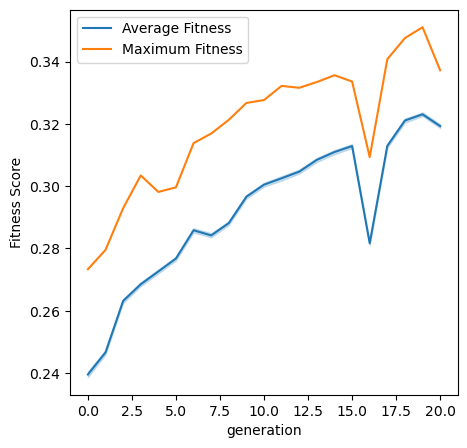

In [51]:
fig , ax = plt.subplots(ncols = 1, figsize = (5,5))

viz_df = score_tracker.copy()
viz_df['generation'] = range(viz_df.shape[0])
viz_df = pd.melt(viz_df, id_vars='generation', value_name='fitness_score')
sns.lineplot(data = viz_df, x = 'generation', y = 'fitness_score', label = 'Average Fitness')

viz_df = pd.DataFrame(score_tracker.max(axis = 1), columns = ['fitness_score'])
viz_df.reset_index(names = 'generation', inplace = True)
sns.lineplot(data = viz_df, x = 'generation', y = 'fitness_score', label = 'Maximum Fitness')
ax.set_ylabel('Fitness Score')
;


In [52]:
feature_combs = best_set


In [53]:
res_all = []
for feature_comb in tqdm(feature_combs):
    res = get_interaction_value(feature_comb[0], feature_comb[1], residuals, X_map, model_coefs)
    res_all.append(res)

res_all = pd.DataFrame(res_all, columns = ['coef', 'pval', 't_statistic'])
_, bh_fdr, _, _ = multipletests(res_all.pval, method='fdr_bh')
res_all['bh_fdr'] = bh_fdr

res_all = pd.concat([
    pd.DataFrame(feature_combs, columns = ['feature_1', 'feature_2']),
    res_all
],
    axis = 1)


100%|██████████████████████████████████████████| 300/300 [00:01<00:00, 170.88it/s]


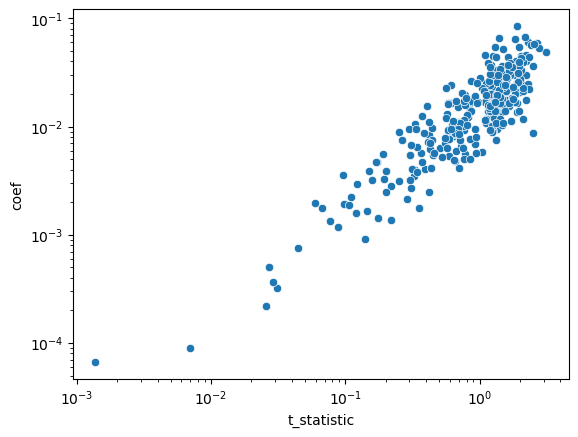

In [45]:
if not v2:
    ALPHA = 0.2
    res_all['coef_scaled'] = np.log1p(res_all.coef.abs())*ALPHA

    res_all['t_statistic_scaled'] = np.log1p(res_all.t_statistic) * (1-ALPHA)

    res_all['fitness_score'] = res_all.coef_scaled + res_all.t_statistic_scaled

    if not np.isclose(np.median(res_all.fitness_score), 
                      score_tracker.max().max()):
        raise ValueError('Something went wrong in recreating the score')
    
    fig, ax = plt.subplots()
    sns.scatterplot(data = res_all, y = 'coef_scaled', x = 't_statistic_scaled')
else:
    fig, ax = plt.subplots()
    
    sns.scatterplot(y = res_all.coef.abs(), x = res_all.t_statistic, ax = ax)
    ax.set_xscale('log')
    ax.set_yscale('log')

In [46]:
res_all.pval.min()

np.float64(0.0019363965726538978)

In [47]:
res_all.bh_fdr.min()

np.float64(0.43710289810014025)

In [48]:
alpha = 0.2
res_all[res_all.bh_fdr <= alpha]

,feature_1,feature_2,coef,pval,t_statistic,bh_fdr


<Axes: xlabel='coef', ylabel='Density'>

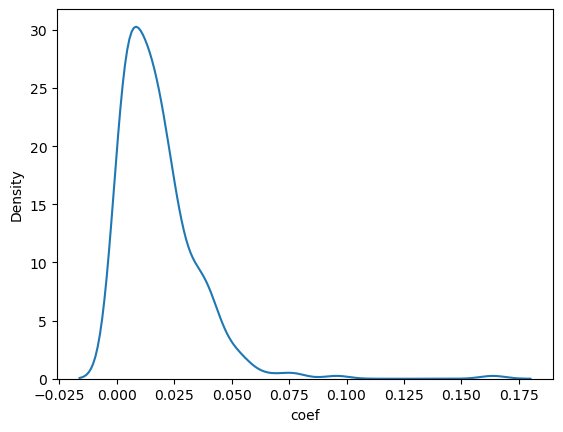

In [39]:
sns.kdeplot(np.log1p(res_all.coef.abs()))

<Axes: xlabel='pval', ylabel='Density'>

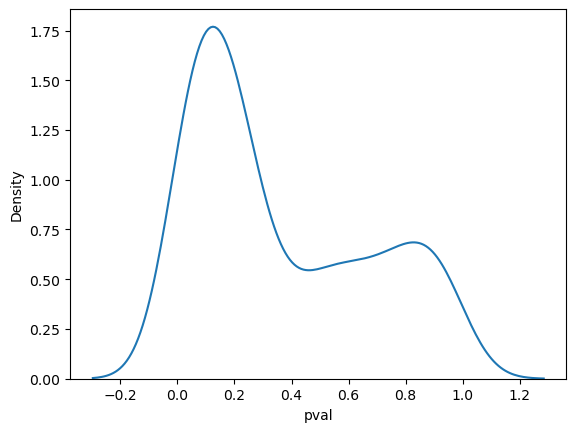

In [40]:
sns.kdeplot(res_all.pval)